convertion of categorical data to numeric data

🔍 Cross‑Validation ROC AUC Scores:
Logistic Regression: 0.907 ± 0.017
SVM (linear): 0.907 ± 0.013
XGBoost: skipped (no predict_proba)
KNN (k=5): 0.887 ± 0.018
Gaussian NB: 0.899 ± 0.028
Decision Tree: 0.781 ± 0.044
Random Forest: 0.920 ± 0.020

📋 Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0     0.9054    0.8171    0.8590        82
           1     0.8636    0.9314    0.8962       102

    accuracy                         0.8804       184
   macro avg     0.8845    0.8742    0.8776       184
weighted avg     0.8823    0.8804    0.8796       184

Accuracy: 0.8804, ROC AUC: 0.9167

📋 SVM (linear) Classification Report:
               precision    recall  f1-score   support

           0     0.9167    0.8049    0.8571        82
           1     0.8571    0.9412    0.8972       102

    accuracy                         0.8804       184
   macro avg     0.8869    0.8730    0.8772       184
weighted avg     0.8837    0.8804   

<Figure size 1200x900 with 0 Axes>

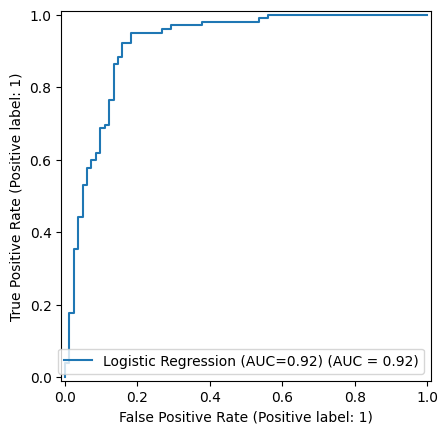

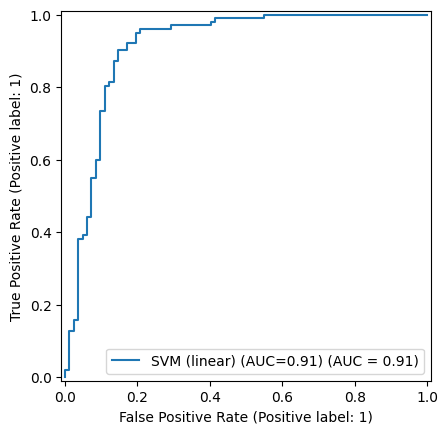

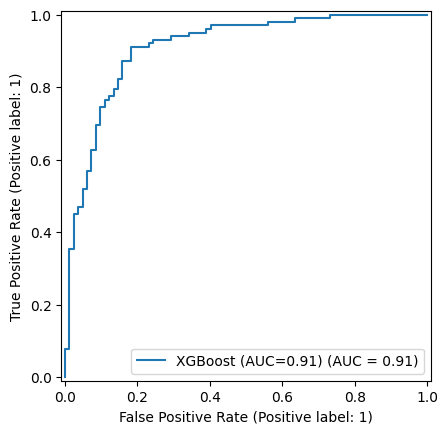

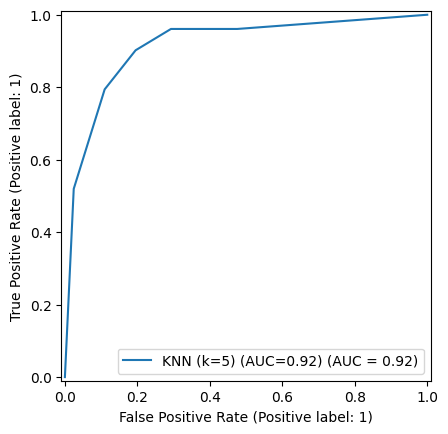

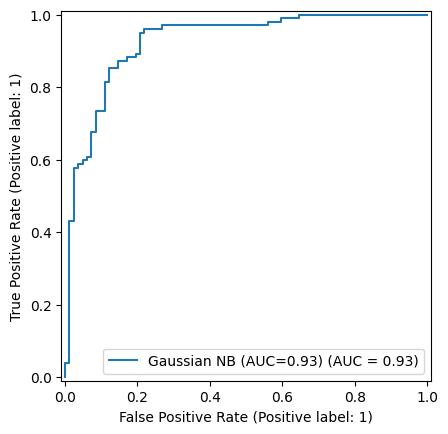

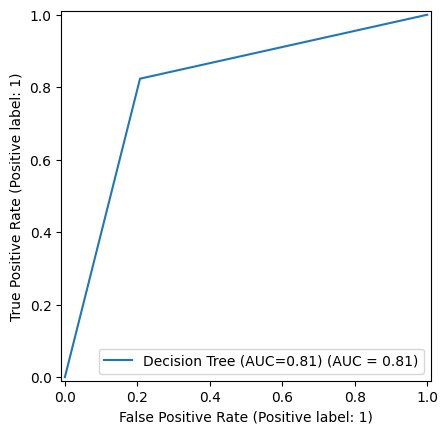

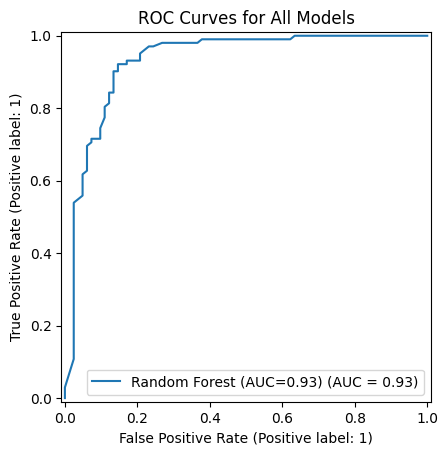

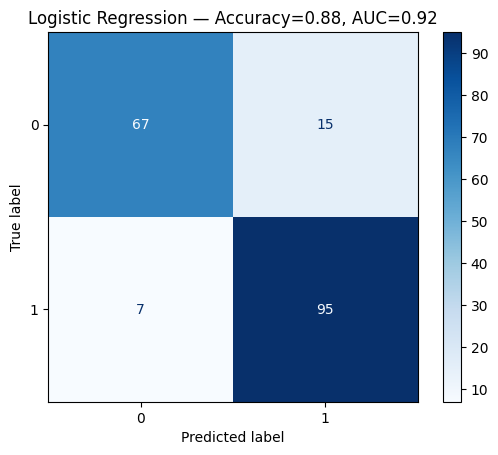

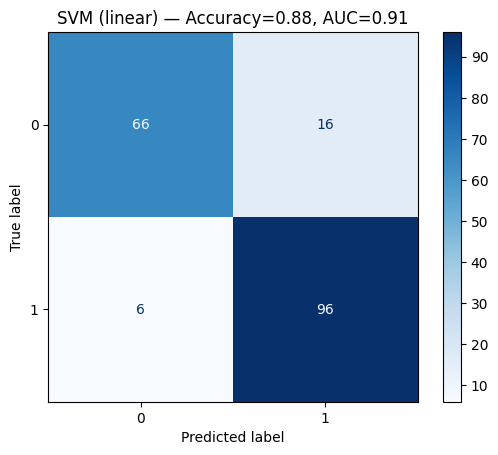

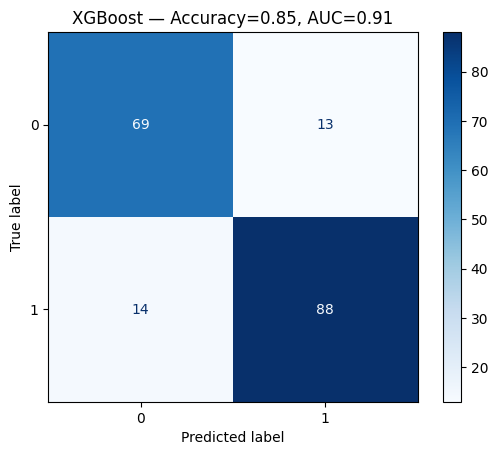

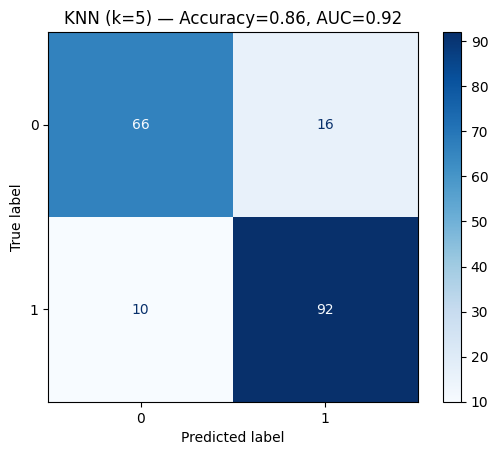

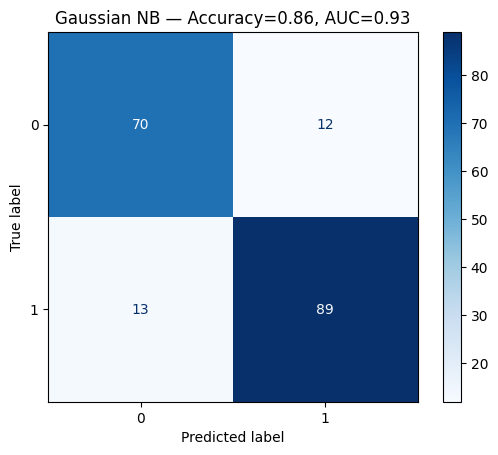

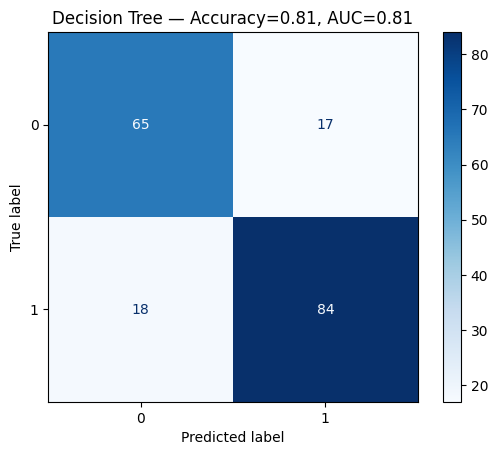

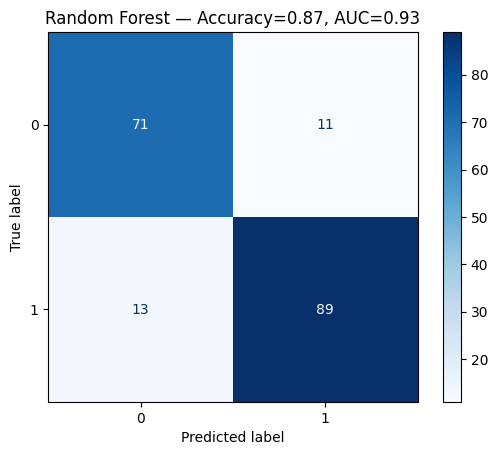


=== Final Model Comparison ===
                 Model  Accuracy   ROC_AUC
0        Random Forest  0.869565  0.931851
1          Gaussian NB  0.864130  0.925634
2  Logistic Regression  0.880435  0.916667
3            KNN (k=5)  0.858696  0.915531
4         SVM (linear)  0.880435  0.912482
5              XGBoost  0.853261  0.910450
6        Decision Tree  0.809783  0.808106

Using Random Forest for live prediction.
Enter patient metrics below. Type 'exit' anytime to quit.

Invalid input—please enter a numeric value or 'exit'.

Prediction: ✔️ No Heart Disease  (Chance: 39.0%)

Exiting...


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, classification_report, accuracy_score, roc_auc_score
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# 1. Load & preprocess data
df = pd.read_csv('heart.csv')
df['Cholesterol'].replace(0, np.nan, inplace=True)
df['Cholesterol'].fillna(df['Cholesterol'].median(), inplace=True)
df = df[df['RestingBP'] != 0]

df['Diastolic_RestingBP'] = (df['RestingBP'] <= 100).astype(int)
df['RestingBP_Category'] = pd.cut(df['RestingBP'], bins=[0,120,129,139,200],
                                  labels=["Normal", "Elevated", "HTN_Stage1", "HTN_Stage2"])
df['Cholesterol_Category'] = pd.cut(df['Cholesterol'], bins=[0,200,230,500],
                                    labels=["Normal", "Borderline", "High"])

import category_encoders as ce
ord_enc = ce.OrdinalEncoder(cols=['ChestPainType','RestingECG','ST_Slope',
                                  'Cholesterol_Category','RestingBP_Category'])
df = ord_enc.fit_transform(df)
ohe = ce.OneHotEncoder(cols=['Sex','ExerciseAngina'], drop_invariant=True)
df = ohe.fit_transform(df)

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# 2. Cross-validation ROC AUC (only for models that support predict_proba)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (linear)": SVC(kernel='linear', probability=True),  # enable predict_proba :contentReference[oaicite:1]{index=1}
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Gaussian NB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

print("🔍 Cross‑Validation ROC AUC Scores:")
cv_scores = {}
for name, clf in models.items():
    try:
        aucs = []
        pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', clf)])
        for train_i, val_i in cv.split(X, y):
            pipe.fit(X.iloc[train_i], y.iloc[train_i])
            proba = pipe.predict_proba(X.iloc[val_i])[:,1]
            aucs.append(roc_auc_score(y.iloc[val_i], proba))
        cv_scores[name] = np.mean(aucs)
        print(f"{name}: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    except AttributeError:
        print(f"{name}: skipped (no predict_proba)")

# 3. Final train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = MinMaxScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# 4. Train, evaluate, ROC & confusion matrix for each model
final_results = []
plt.figure(figsize=(12,9))
for name, clf in models.items():
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_test_s)
    acc = accuracy_score(y_test, y_pred)
    # obtain score/proba or decision_function
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test_s)[:,1]
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test_s)
    else:
        y_score = None

    auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    final_results.append((name, acc, auc))

    print(f"\n📋 {name} Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    print(f"Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}" if y_score is not None else f"Accuracy: {acc:.4f}, ROC AUC: N/A")

    if y_score is not None:
        RocCurveDisplay.from_predictions(y_test, y_score, name=f"{name} (AUC={auc:.2f})")

plt.title("ROC Curves for All Models")
plt.legend(loc='lower right')
plt.show()

# 5. Confusion matrices for each model
for name, acc, auc in final_results:
    clf = models[name]
    cm = confusion_matrix(y_test, clf.predict(X_test_s))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{name} — Accuracy={acc:.2f}, AUC={auc:.2f}" if not np.isnan(auc) else f"{name} — Accuracy={acc:.2f}")
    plt.show()

# 6. Summary table
summary = pd.DataFrame(final_results, columns=["Model", "Accuracy", "ROC_AUC"])
print("\n=== Final Model Comparison ===")
print(summary.sort_values(by="ROC_AUC", ascending=False).reset_index(drop=True))


def get_valid_number(prompt, dtype=float):
    """Prompt until the user enters a valid number or 'exit'."""
    while True:
        s = input(f"{prompt}: ")
        if s.lower() == 'exit':
            return None
        try:
            return dtype(s)
        except ValueError:
            print("Invalid input—please enter a numeric value or 'exit'.")

# Assuming X.columns is your feature list
best_clf = models["Random Forest"]
print("\nUsing Random Forest for live prediction.")
print("Enter patient metrics below. Type 'exit' anytime to quit.\n")

def get_user_input():
    values = []
    for feat in X.columns:
        val = get_valid_number(feat, float)
        if val is None:
            return None
        values.append(val)
    return np.array(values).reshape(1, -1)

while True:
    user_sample = get_user_input()
    if user_sample is None:
        print("Exiting...")
        break
    sample_scaled = scaler.transform(user_sample)
    pred = best_clf.predict(sample_scaled)[0]
    proba = best_clf.predict_proba(sample_scaled)[0, 1]
    label = "❤️ Heart Disease" if pred == 1 else "✔️ No Heart Disease"
    print(f"\nPrediction: {label}  (Chance: {proba*100:.1f}%)\n")